In [1]:
import scipy as sp
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.bicycle_GAN import *

In [2]:
task='TRAIN'
#task='TEST'

# Option to save and restore hyperparameters

PATH='HCAL_bycicleGAN_test35'

In [3]:
if task =='TRAIN' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes_enc = hyper_dict['g_sizes_enc']
    g_sizes_dec = hyper_dict['g_sizes_dec']
    e_sizes = hyper_dict['e_sizes']
    preprocess = hyper_dict['preprocess']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    cycl_weight=hyper_dict['cycl_weight']
    latent_weight=hyper_dict['latent_weight']
    kl_weight=hyper_dict['kl_weight']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    vae_steps=hyper_dict['vae_steps']
    
elif task=='TRAIN' and not os.path.exists(PATH+'/hyper_parameters.pkl'):
    
    reco_path = '/disk/lhcb_data/davide/HCAL_project/piplus_cells_inout/piplus/reco/'
    true_path = '/disk/lhcb_data/davide/HCAL_project/piplus_cells_inout/piplus/true/'
    #reco_path = '/disk/lhcb_data/davide/HCAL_project_full_event/reco/'
    #true_path = '/disk/lhcb_data/davide/HCAL_project_full_event/true/'
    n_batches = 1
    test_size = 5000
    validating_size=1000
    
    LEARNING_RATE = 2e-4
    BETA1 = 0.5
    BATCH_SIZE = 16
    EPOCHS = 4
    SAVE_SAMPLE_PERIOD = 200
    SEED = 1
    preprocess=False
    cost_type='GAN'
    
    latent_weight=100
    cycl_weight=10
    kl_weight=1
    discr_steps=1
    gen_steps=4
    vae_steps=4
    
    latent_dims=16
    ndf = 16
    ngf = 16
    nef = 16
    s = 2
    f = 4
    d = 0.8
    
    stddev_d=0.02
    stddev_g=0.02
    stddev_e=0.02


    g_sizes_enc={
        'latent_dims':latent_dims,
    
        'conv_layers': [
                            (ngf/2, f,   s,  False, 1, lrelu, tf.truncated_normal_initializer(stddev_g)), #(batch, 52, 64, 1) =>  (batch, 26, 32, ngf)
                            (ngf,   f,   s, 'bn',  d,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 26, 32, ngf) => (batch, 13, 16, ngf*2)
                            (ngf*2, f,   s, 'bn',  1,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 13, 16, ngf*4) => (batch, 7, 8, ngf*4)
                            (ngf*4, f,   s, 'bn',  1,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 7, 8, ngf*4) => (batch, 4, 4, ngf*4)
                            (ngf*8, f,   s, 'bn',  d,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 4, 4, ngf*4) => (batch, 2, 2, ngf*4)
                            #(ngf*8, f, s, 'bn', 1, lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 2, 2, ngf*4) => (batch, 1, 1, ngf*4)
                        
                       ],
    }
    
    g_sizes_dec={
    
         
         'deconv_layers': [
    
                            (ngf*4, f,   s,  'bn',   1, tf.nn.softplus, tf.truncated_normal_initializer(stddev_g)),#(batch, 1, 1, ngf*4) => (batch, 2, 2, ngf*4*2)
                            (ngf*2, f,   s,  'bn',   d, tf.nn.softplus, tf.truncated_normal_initializer(stddev_g)),#(batch, 2, 2, ngf*4*2) => (batch, 4, 4, ngf*4*2)
                            (ngf,   f,   s,  'bn',   1, tf.nn.softplus, tf.truncated_normal_initializer(stddev_g)),#(batch, 4, 4, ngf*4*2) => (batch, 7, 8, ngf*4*2)
                            (ngf/2, f,   s,  'bn',   1, tf.nn.softplus, tf.truncated_normal_initializer(stddev_g)),#(batch, 7, 8, ngf*4*2) => (batch, 13, 16, ngf*2*2)
                            (1,     f,   s,   False, d, tf.nn.softplus, tf.truncated_normal_initializer(stddev_g)),#(batch, 26, 32, ngf*2) => (batch, 52, 64, 1)
                       
                         ],  
    }
    
    
    d_sizes={
        
         'conv_layers': [
                             (ndf/2,  f, s,  False, 1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 52, 64, 2) => (batch, 26, 32, ndf)
                             (ndf,    f, s, 'bn',   d, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
                             (ndf*2,  f, s, 'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 13, 16, ndf*2) => (batch, 7, 8, ndf*4)
                             (ndf*4,  f, s, 'bn',   d, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 7, 8, ndf*4) => (batch, 7, 8, ndf*8)
                             (ndf*8,  f, 1, 'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 7, 8, ndf*8) => (batch, 7, 8, ndf*8)
                             
                        ],
                        
         
         'dense_layers': [
                             (ndf*32, 'bn',  d, lrelu, tf.truncated_normal_initializer(stddev_d)),
                             #(ndf*4,  'bn',  d, lrelu, tf.truncated_normal_initializer(stddev_d)),             
                             (ndf,   False,  d, lrelu, tf.truncated_normal_initializer(stddev_d))],
        
         'readout_layer_w_init':tf.truncated_normal_initializer(stddev_d),
    }
    

    
    e_sizes={
        'latent_dims':latent_dims,
        
        #'conv_layer_0':[
        #                    (nef,   f, s, False, 1,lrelu, tf.truncated_normal_initializer(stddev_e)),
        #                ],
        'conv_layers':[
            
                            (nef/2, f,   s,   False, 1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef,   f,   s,   'bn',  1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*2, f,   s,   'bn',  d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*4, f,   s,   'bn',  1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*8, f,   s,   'bn',  d, lrelu, tf.random_normal_initializer(stddev_e)),
                        ],

        
        #'convblock_layer_0':[
        #                     (nef*2, 1, s, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
        #                     (nef*2, f, 1, 'bn', d, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 13, 16, ndf*2)
        #                     (nef*2, 1, 1, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 13, 16, ndf*2)
        #                     
        #                ],
        #'convblock_shortcut_layer_0':[
        #                    (nef*2, 1, s, False, 1, tf.random_normal_initializer(stddev_e))
        #                ],
        #
        #'convblock_layer_1':[
        #                     (nef*4, 1, s, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
        #                     (nef*4, f, 1, 'bn', d, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 13, 16, ndf*2)
        #                     (nef*4, 1, 1, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 13, 16, ndf*2)
        #                     
        #                ],
        #'convblock_shortcut_layer_1':[
        #                    (nef*4, 1, s, False, 1, tf.random_normal_initializer(stddev_e))
        #                ],
        #'convblock_layer_2':[
        #                     (nef*4, 1, s, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
        #                     (nef*4, f, 1, 'bn', d, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 7, 8, ndf*4)
        #                     (nef*4, 1, 1, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 7, 8, ndf*4) => (batch, 7, 8, ndf*8)
        #                     
        #                ],
        #
        #'convblock_shortcut_layer_2':[
        #                    (nef*4, 1, s, False, 1, tf.random_normal_initializer(stddev_e))
        #                ],
        
       # 'convblock_layer_3':[
       #                       (nef*8, 1, s, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
       #                       (nef*8, f, 1, 'bn', 1, lrelu, tf.random_normal_initializer(stddev_e)), #(batch, 13, 16, ndf*2) => (batch, 7, 8, ndf*4)
       #                       (nef*8, 1, 1, 'bn', 1, tf.nn.relu,tf.random_normal_initializer(stddev_e)), #(batch, 7, 8, ndf*4) => (batch, 7, 8, ndf*8)
       #                       
       #                  ],
       # 'convblock_shortcut_layer_3':[
       #                      (nef*8, 1, s, False, 1, tf.random_normal_initializer(stddev_e))
       #                     ],

        
        'dense_layers':[    
                            (nef*16, 'bn',   d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*8, 'bn',   d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef,   False, d, lrelu, tf.random_normal_initializer(stddev_e)),
                      
                        ],
        'readout_layer_w_init':tf.random_normal_initializer(stddev_e)
        
    }

In [4]:
if task == 'TEST' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    #true_path_K = hyper_dict['true_path_K']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes_enc = hyper_dict['g_sizes_enc']
    g_sizes_dec = hyper_dict['g_sizes_dec']
    e_sizes = hyper_dict['e_sizes']
    preprocess = hyper_dict['preprocess']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    cycl_weight=hyper_dict['cycl_weight']
    latent_weight=hyper_dict['latent_weight']
    kl_weight=hyper_dict['kl_weight']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    vae_steps=hyper_dict['vae_steps']

In [5]:
dim=1
select=False
if preprocess=='normalise':
    train_true, test_true, min_true, max_true, train_reco, test_reco, min_reco, max_reco = load_data(true_path, reco_path, n_batches, select=select, n_cells=dim*dim, energy_fraction=1, preprocess=preprocess, test_size=test_size)
else:
    train_true, test_true, train_reco, test_reco = load_data(true_path, reco_path, n_batches,  select=select, n_cells=None, energy_fraction=1, preprocess=preprocess, test_size=test_size)
    
train_true, train_reco = delete_undetected_events_double(train_true, train_reco)
test_true, test_reco = delete_undetected_events_double(test_true, test_reco)


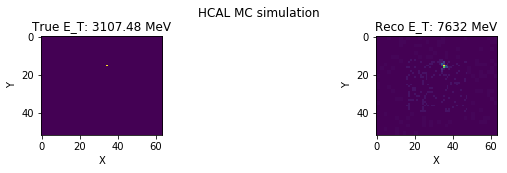

In [6]:
if preprocess != False:
    draw_one_sample(train_true, train_reco, preprocess,
                    min_true=min_true, max_true=max_true, 
                    min_reco=min_reco, max_reco=max_reco,
                    save=False, PATH=PATH
                   )
else:
    draw_one_sample(train_true,train_reco)

In [7]:
def HCAL():

    
    tf.reset_default_graph()
    
    _, n_H_A, n_W_A ,n_C = train_true.shape
    _, n_H_B, n_W_B ,n_C = train_reco.shape
    
    gan = bicycle_GAN(n_H_A, n_W_A, n_H_B, n_W_B, n_C,
                   min_true=min_true, max_true=max_true, 
                   min_reco=min_reco, max_reco=max_reco,
                   d_sizes=d_sizes, g_sizes_enc=g_sizes_enc, g_sizes_dec=g_sizes_dec, e_sizes=e_sizes,
                   lr=LEARNING_RATE, beta1=BETA1,
                   preprocess=preprocess, cost_type=cost_type,
                   cycl_weight=cycl_weight, latent_weight=latent_weight, kl_weight=kl_weight,
                   discr_steps=discr_steps, gen_steps=gen_steps, vae_steps=vae_steps,
                   batch_size=BATCH_SIZE, epochs=EPOCHS,
                   save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed= SEED)
    
    vars_to_train= tf.trainable_variables()
        
    if task == 'TRAIN':
        
        init_op = tf.global_variables_initializer()
        
        
    if task == 'TEST':
        
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    saver=tf.train.Saver()
    # Add ops to save and restore all the variables.
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)
        
        if task=='TRAIN':
            
            if os.path.exists(PATH+'/'+PATH+'bicycle.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'bicycle.ckpt')
                print('Model restored.')
                
            gan.set_session(sess)
            gan.fit(train_true,train_reco, validating_size)
            
            save_all = saver.save(sess, PATH+'/'+PATH+'bicycle.ckpt')
            print("Model saved in path: %s" % save_all)
                  
                       
        if task=='TEST':
            
            print('\n Evaluate model on test set...')
            
            if os.path.exists(PATH+'/'+PATH+'bicycle.ckpt.index'):
                saver.restore(sess, PATH+'/'+PATH+'bicycle.ckpt')
                
            print('Model restored.')
            
            gan.set_session(sess)
        
        #test_reco_NN=gan.get_samples_A_to_B(test_true.reshape(test_true.shape[0],n_H_A,n_W_A,n_C))
        test_reco_NN=np.zeros_like(test_true)
        t0 = datetime.now()
        for i in range(len(test_true)):
            test_reco_NN[i]=gan.get_sample_A_to_B(test_true[i].reshape(1,n_H_A,n_W_A,n_C))
        per_evt_time=(datetime.now() - t0)/len(test_reco)
        print('Per event simulation time {0}'.format(per_evt_time))
        done = False

        while not done:
            
            #j = int(input("Input event number"))
            if preprocess:
                draw_nn_sample(test_true, test_reco, 1, preprocess,
                              min_true=min_true, max_true=max_true, 
                              min_reco=min_reco, max_reco=max_reco,
                              f=gan.get_sample_A_to_B, save=False, is_training=False, PATH=PATH)
            else:
                draw_nn_sample(test_true, test_reco, 1, preprocess,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
        
        done = False
        while not done:
            
            if preprocess:
                draw_nn_sample(test_true, test_reco, 20, preprocess,
                              min_true=min_true, max_true=max_true, 
                              min_reco=min_reco, max_reco=max_reco,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
            else:
                draw_nn_sample(test_true, test_reco, 20, preprocess,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
                
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
        
        return test_reco_NN

Convolutional Network architecture detected for discriminator B
Convolutional Network architecture detected for encoder B
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 16)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 512)
Generator output shape (?, 52, 64, 1)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 512)
Generator output shape (?, 52, 64, 1)
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 16)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 16)
Logits shape (?, 1)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 16)
Logits shape (?, 1)
Discriminator_B
Input for co

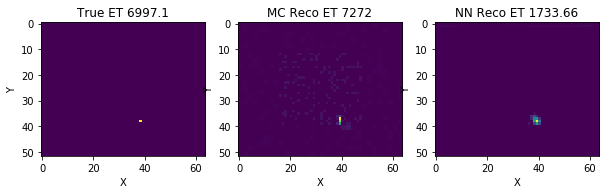

In [ ]:
if __name__=='__main__':
    
    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
            
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        test_reco_NN = HCAL()
   
    elif task == 'TEST':
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            test_reco_NN = HCAL()

In [ ]:
max_MC=train_reco.max()
max_NN=test_reco_NN.max()

In [ ]:
print('Max NN {0}, Max_MC {1}'.format(max_NN, max_MC, ))

In [ ]:
test_reco_NN_rescaled=(test_reco_NN/test_reco_NN.max())*max_MC

In [ ]:
print(test_reco_NN_rescaled.max())

In [ ]:
if preprocess:
    reco_MC_hist = denormalise(test_reco, min_reco, max_reco).reshape(test_reco.shape[0], test_reco.shape[1]*test_reco.shape[2])
    reco_MC_hist = np.sum(reco_MC_hist,axis=1)
    max_E=np.max(reco_MC_hist)
    
    reco_NN_hist = denormalise(test_reco_NN, min_reco, max_reco).reshape(test_reco_NN.shape[0], test_reco_NN.shape[1]*test_reco_NN.shape[2])
    reco_NN_hist = np.sum(reco_NN_hist,axis=1)
    max_NN = np.max(reco_NN_hist)
    
    true_hist = denormalise(test_true, min_reco, max_true).reshape(test_true.shape[0], test_true.shape[1]*test_true.shape[2])
    true_hist = np.sum(true_hist,axis=1)
    max_true_E=np.max(true_hist)
else:
    reco_MC_hist = test_reco.reshape(test_reco.shape[0], test_reco.shape[1]*test_reco.shape[2])
    reco_MC_hist = np.sum(reco_MC_hist,axis=1)
    max_E=np.max(reco_MC_hist)
    
    reco_NN_hist = test_reco_NN_rescaled.reshape(test_reco_NN_rescaled.shape[0], test_reco_NN.shape[1]*test_reco_NN.shape[2])
    reco_NN_hist = np.sum(reco_NN_hist,axis=1)
    max_NN = np.max(reco_NN_hist)
    
    true_hist = test_true.reshape(test_true.shape[0], test_true.shape[1]*test_true.shape[2])
    true_hist = np.sum(true_hist,axis=1)
    max_true_E=np.max(true_hist)

In [ ]:
reco_NN_hist=(reco_NN_hist/reco_NN_hist.max())*reco_MC_hist.max()

In [ ]:
#if preprocess:
#    reco_MC_hist = denormalise(train_reco, min_reco, max_reco).reshape(train_reco.shape[0], train_reco.shape[1]*train_reco.shape[2])
#    reco_MC_hist = np.sum(reco_MC_hist,axis=1)
#    max_E=np.max(reco_MC_hist)
#    
#    reco_NN_hist = denormalise(test_reco_NN, min_reco, max_reco).reshape(test_reco_NN.shape[0], test_reco_NN.shape[1]*test_reco_NN.shape[2])
#    reco_NN_hist = np.sum(reco_NN_hist,axis=1)
#    max_NN = np.max(reco_NN_hist)
#    
#    true_hist = denormalise(train_true, min_true, max_true).reshape(train_true.shape[0], train_true.shape[1]*train_true.shape[2])
#    true_hist = np.sum(true_hist,axis=1)
#    max_true_E=np.max(true_hist)

In [ ]:
diffNN = reco_NN_hist-true_hist
diffMC = reco_MC_hist-true_hist

plt.subplot(1,2,1)
plt.tick_params(labelsize=15);
h_reco = plt.hist(diffMC,bins=30, edgecolor='black');
plt.xlabel('ET recoMC - ET true', fontsize=15)
plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by MC', fontsize=15)
plt.subplot(1,2,2)
plt.tick_params(labelsize=15);
h_nn = plt.hist(diffNN,bins=30, edgecolor='black');
plt.xlabel('ET recoNN - ET true', fontsize=15)
plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by NN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(12,4)
plt.savefig(PATH+'/resolution.eps', format='eps', dpi=100)


plt.hist(diffNN, bins=30);

In [ ]:
diffNN.mean(), diffNN.std()

In [ ]:
diffMC.mean(), diffMC.std()

In [ ]:
np.where(true_hist==0)

In [ ]:
plt.subplot(1,3,1)
plt.tick_params(labelsize=12);
h_reco = plt.hist(true_hist/1000,bins=30, edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)
plt.ylabel('dN/dE_T', fontsize=15)
plt.title('Pion True E_T', fontsize=15)
plt.subplot(1,3,2)
plt.tick_params(labelsize=12);
h_reco = plt.hist(reco_MC_hist/1000,bins=30, edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Pion Reco E_T from MC', fontsize=15)
plt.subplot(1,3,3)
plt.tick_params(labelsize=12);
h_nn = plt.hist(reco_NN_hist/1000,bins=30, edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Pion Reco E_T from BicycleGAN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(16,4)
plt.savefig(PATH+'/distribution.eps', format='eps', dpi=100)

In [ ]:
diff=plt.bar(np.arange(0, 30), 
             height=(h_nn[0]-h_reco[0]), edgecolor='black', 
             linewidth=1, color='lightblue',width = 1, align = 'edge') 
plt.xlabel('E (GeV)')
plt.ylabel('dN/dE')
plt.title("NN output - MC output")
fig = plt.gcf()
fig.set_size_inches(12,4)
plt.savefig(PATH+'/difference.eps', format='eps',dpi=100)

In [ ]:
four_cells_diff_NN= np.array([
       four_cells(test_reco_NN_rescaled[i]).sum() - test_true[i].sum()  for i in range(len(test_reco))
])    
four_cells_diff_MC= np.array([
       four_cells(test_reco[i]).sum() - test_true[i].sum() for i in range(len(test_reco))
])
plt.hist(four_cells_diff_NN, bins=30, label = 'NN-ET_true')
plt.hist(four_cells_diff_MC, bins=30, label = 'MC-ET_true', histtype='step')
plt.legend(loc=2);
plt.xlabel('Sum of 4 max cells ET  - ET true (GeV)')
plt.ylabel('dN/dET')
plt.savefig(PATH+'/four_cells_diff_combined.eps', format='eps', dpi=100)

In [ ]:
four_cells_diff= four_cells_diff_NN-four_cells_diff_MC
plt.hist(four_cells_diff_NN-four_cells_diff_MC, bins=20, label = 'MC-NN');
plt.legend();
print('four cells diff mean {0}, std {1}'.format(four_cells_diff.mean(), four_cells_diff.std()))
plt.savefig(PATH+'/four_cells_diff.eps', format='eps', dpi=100)

In [ ]:
hyper_dict={'LEARNING_RATE':LEARNING_RATE,
            'BETA1':BETA1,
            'BATCH_SIZE':BATCH_SIZE,
            'EPOCHS':EPOCHS,
            'SAVE_SAMPLE_PERIOD':SAVE_SAMPLE_PERIOD,
            'SEED':SEED,
            'd_sizes':d_sizes,
            'g_sizes_dec':g_sizes_dec,
            'g_sizes_enc':g_sizes_enc,
            'e_sizes':e_sizes,
            'preprocess':preprocess,
            'cost_type':cost_type,
            'validating_size':validating_size,
            'test_size':test_size,
            'n_batches':n_batches,
            'reco_path':reco_path,
            'true_path':true_path,
            'discr_steps':discr_steps,
            'gen_steps':gen_steps,
            'vae_steps':vae_steps,
            'latent_weight':latent_weight,
            'cycl_weight':cycl_weight,
            'kl_weight':kl_weight,
           }

In [ ]:
with open(PATH+'/hyper_parameters.pkl', 'wb') as f:  
    pickle.dump(hyper_dict, f)